# $b'B_o$ computation

In [1]:
# obs: talvez tenha que cropar um quadrado pequeno pra fazer tudo
# o crte dos CROCO estao errados

In [2]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [70]:
dxx=0.5

In [4]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [5]:
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:])

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:])

In [55]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [56]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,:,200:-200].compute();
tf=tf[:-1,1:-1,1:-1]

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,:,200:-200].compute();
tt=tt[:-1,1:-1,1:-1]

shf=varf.shflx.groupby("time_counter.dayofyear").mean()
shf=shf.chunk(chunks=chunks_new);
shf=shf[:,:,200:-200].compute();
shf=shf[:-1,1:-1,1:-1]

sht=vart.shflx.groupby("time_counter.dayofyear").mean()
sht=sht.chunk(chunks=chunks_new);
sht=sht[:,:,200:-200].compute();
sht=sht[:-1,1:-1,1:-1]


sf=varf.salt.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,:,200:-200].compute();
sf=sf[:-1,1:-1,1:-1]

st=vart.salt.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,:,200:-200].compute();
st=st[:-1,1:-1,1:-1]


CPU times: user 1min 16s, sys: 2min 1s, total: 3min 17s
Wall time: 32.8 s


# Computing $Bo_t$ and $b_T$

In [285]:
N2r=(5.2*10**-3)**2

In [220]:
cp=gsw.cp_t_exact(sf,tf,p=0).mean()
rho=1024
g=9.8

In [222]:
ct_f=gsw.CT_from_t(sf,tf,p=0)
alpha_f=gsw.alpha(sf,ct_f,p=0)
# lv_f=gsw.latentheat_evap_CT(sf,ct_f)


ct_t=gsw.CT_from_t(st,tt,p=0)
alpha_t=gsw.alpha(st,ct_t,p=0)
# lv_t=gsw.latentheat_evap_CT(st,ct_t)

In [224]:
Bot_f=-(alpha_f*g*shf)/(rho*cp)
Bot_t=-(alpha_t*g*sht)/(rho*cp)

bt_f=alpha_f*g*(tf-tf.mean(axis=1).mean(axis=1))#spatial reference
bt_t=alpha_t*g*(tt-tt.mean(axis=1).mean(axis=1))#spatial reference

# bt_f=alpha_f.mean()*g*(tf-tf.mean())#time and spatial reference
# bt_t=alpha_t.mean()*g*(tt-tt.mean())#time and spatial reference


# Computing $Bo_s$ and $b_S$

In [60]:
%%time
chunks_new={'time_counter':40}

lhtf=varfw.LH
lhtf=lhtf.chunk(chunks=chunks_new);
lhtf=lhtf[:,30:-30,30:200].compute();
lhtf=lhtf[:,1:-1,1:-1]

lhtt=vartw.LH
lhtt=lhtt.chunk(chunks=chunks_new);
lhtt=lhtt[:,30:-30,30:200].compute();
lhtt=lhtt[:,1:-1,1:-1]

Pf=varfw.RAIN
Pf=Pf.chunk(chunks=chunks_new);
Pf=Pf[:,30:-30,30:200].compute();
Pf=Pf[:,1:-1,1:-1]

Pt=vartw.RAIN
Pt=Pt.chunk(chunks=chunks_new);
Pt=Pt[:,30:-30,30:200].compute();
Pt=Pt[:,1:-1,1:-1]


CPU times: user 294 ms, sys: 210 ms, total: 503 ms
Wall time: 338 ms


In [228]:
L=gsw.latentheat_evap_CT(sf,ct_f).mean() #J   #/1000 #kJ

In [229]:
Evap_f=lhtf/(L*rho)# m/s   #*86400
Evap_t=lhtt/(L*rho)# m/s   #*86400 #mm/day

beta_f=gsw.beta(sf,ct_f,p=0)
beta_t=gsw.beta(st,ct_t,p=0)

In [230]:
EP_f=Evap_f.mean(axis=1).mean(axis=1)-(Pf.mean(axis=1).mean(axis=1)/(86400*1000));
EP_f=EP_f.assign_coords(DOY=('time_counter',sf.dayofyear.data))
EP_f=EP_f.drop(['time_counter','time_centered'])
EP_f=EP_f.rename({'time_counter':'dayofyear'})



EP_t=Evap_t.mean(axis=1).mean(axis=1)-(Pt.mean(axis=1).mean(axis=1)/(86400*1000));
EP_t=EP_t.assign_coords(DOY=('time_counter',st.dayofyear.data))
EP_t=EP_t.drop(['time_counter','time_centered'])
EP_t=EP_t.rename({'time_counter':'dayofyear'})

In [231]:
Bos_f=(g*beta_f)*(sf)*(EP_f)
Bos_t=(g*beta_t)*(st)*(EP_t)

bs_f=-g*beta_f*(sf-sf.mean(axis=1).mean(axis=1))
bs_t=-g*beta_t*(st-st.mean(axis=1).mean(axis=1))

# bs_f=-g*beta_f*(sf[:-1,:,:]-sf.mean())
# bs_t=-g*beta_t*(st[:-1,:,:]-st.mean())

In [232]:
%%time
with ProgressBar():
    btBt_f=xrft.isotropic_cross_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bot_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real
    btBt_t=xrft.isotropic_cross_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bot_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real

CPU times: user 17min 3s, sys: 1h 13min 7s, total: 1h 30min 11s
Wall time: 1min 58s


In [233]:
%%time
with ProgressBar():
    bsBs_f=xrft.isotropic_cross_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bos_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real
    bsBs_t=xrft.isotropic_cross_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bos_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real

CPU times: user 18min 5s, sys: 1h 17min 27s, total: 1h 35min 32s
Wall time: 2min 2s


In [234]:
%%time
with ProgressBar():
    btBs_f=xrft.isotropic_cross_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bos_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real
    btBs_t=xrft.isotropic_cross_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bos_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real

CPU times: user 17min 50s, sys: 1h 16min 33s, total: 1h 34min 23s
Wall time: 2min 1s


In [235]:
%%time
with ProgressBar():
    bsBt_f=xrft.isotropic_cross_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bot_f.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real
    bsBt_t=xrft.isotropic_cross_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),Bot_t.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real

CPU times: user 17min 50s, sys: 1h 17min 11s, total: 1h 35min 2s
Wall time: 2min 1s


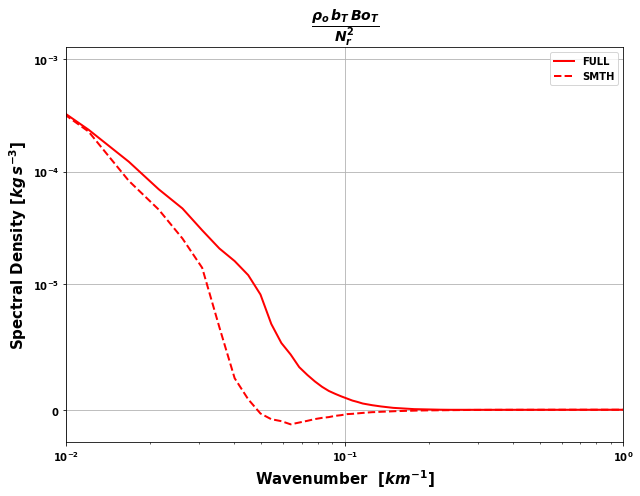

In [338]:
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,(rho/N2r)*btBt_f.mean(axis=0),label='FULL',linewidth=2,color='red')
plt.plot(btBt_t.freq_r/dxx,(rho/N2r)*btBt_t.mean(axis=0),'--',label='SMTH',linewidth=2,color='red')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{\rho_o \,b_T \,Bo_T}{N^2_r}$',fontweight='light',fontsize=20)
plt.ylabel(r'Spectral Density [$kg\,s^{-3}$]',fontweight='bold',fontsize=15)


plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)

plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bTBoT_spectral.png')



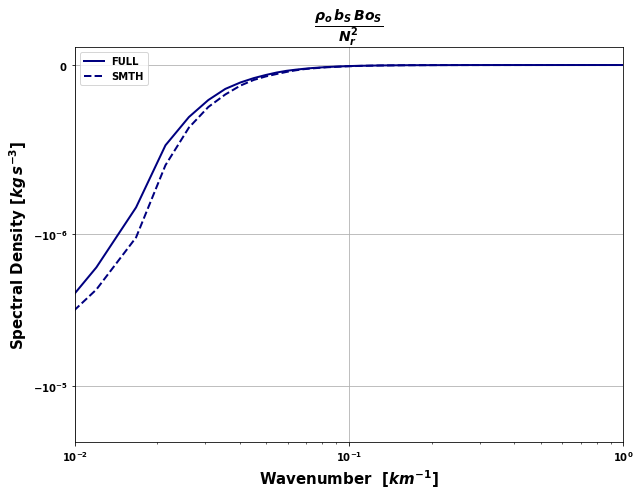

In [339]:
plt.figure(figsize=(9,7))


plt.plot(bsBs_f.freq_r/dxx,(rho/N2r)*bsBs_f.mean(axis=0),label='FULL',linewidth=2,color='navy')
plt.plot(bsBs_t.freq_r/dxx,(rho/N2r)*bsBs_t.mean(axis=0),'--',label='SMTH',linewidth=2,color='navy')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{\rho_o \,b_S \,Bo_S}{N^2_r}$',fontweight='light',fontsize=20)

plt.ylabel(r'Spectral Density [$kg\,s^{-3}$]',fontweight='bold',fontsize=15)



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)

plt.xlim(1/100,1)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bSBoS_spectral.png')



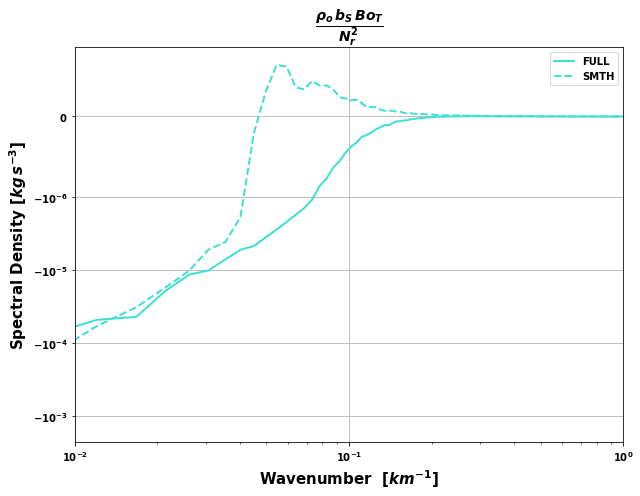

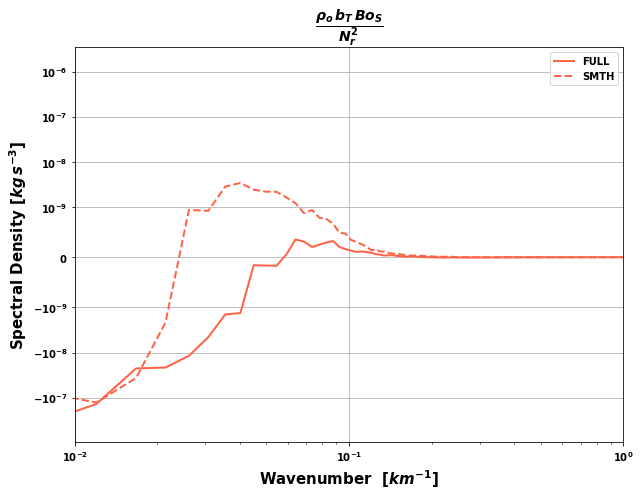

In [341]:
plt.figure(figsize=(9,7))


plt.plot(bsBt_f.freq_r/dxx,(rho/N2r)*bsBt_f.mean(axis=0),label='FULL',linewidth=2,color='turquoise')
plt.plot(bsBt_t.freq_r/dxx,(rho/N2r)*bsBt_t.mean(axis=0),'--',label='SMTH',linewidth=2,color='turquoise')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{\rho_o \,b_S \,Bo_T}{N^2_r}$',fontweight='light',fontsize=20)


plt.ylabel(r'Spectral Density [$kg\,s^{-3}$]',fontweight='bold',fontsize=15)




plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)

plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bSBoT_spectral.png')





plt.figure(figsize=(9,7))


plt.plot(btBs_f.freq_r/dxx,(rho/N2r)*btBs_f.mean(axis=0),label='FULL',linewidth=2,color='tomato')
plt.plot(btBs_t.freq_r/dxx,(rho/N2r)*btBs_t.mean(axis=0),'--',label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-9)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{\rho_o \,b_T \,Bo_S}{N^2_r}$',fontweight='light',fontsize=20)

plt.ylabel(r'Spectral Density [$kg\,s^{-3}$]',fontweight='bold',fontsize=15)



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)

plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bTBoS_spectral.png')




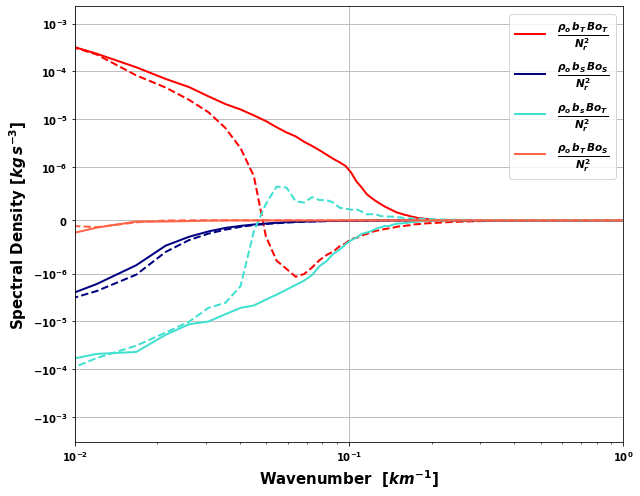

In [342]:
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,(rho/N2r)*btBt_f.mean(axis=0),label=r'$\frac{\rho_o \,b_T \,Bo_T}{N^2_r}$',linewidth=2,color='red')
plt.plot(btBt_t.freq_r/dxx,(rho/N2r)*btBt_t.mean(axis=0),'--',linewidth=2,color='red')


plt.plot(bsBs_f.freq_r/dxx,(rho/N2r)*bsBs_f.mean(axis=0),label=r'$\frac{\rho_o \,b_S \,Bo_S}{N^2_r}$',linewidth=2,color='navy')
plt.plot(bsBs_t.freq_r/dxx,(rho/N2r)*bsBs_t.mean(axis=0),'--',linewidth=2,color='navy')


plt.plot(bsBt_f.freq_r/dxx,(rho/N2r)*bsBt_f.mean(axis=0),label=r'$\frac{\rho_o \,b_s \,Bo_T}{N^2_r}$',linewidth=2,color='turquoise')
plt.plot(bsBt_t.freq_r/dxx,(rho/N2r)*bsBt_t.mean(axis=0),'--',linewidth=2,color='turquoise')



plt.plot(btBs_f.freq_r/dxx,(rho/N2r)*btBs_f.mean(axis=0),label=r'$\frac{\rho_o \,b_T \,Bo_S}{N^2_r}$',linewidth=2,color='tomato')
plt.plot(btBs_t.freq_r/dxx,(rho/N2r)*btBs_t.mean(axis=0),'--',linewidth=2,color='tomato')


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [$kg\,s^{-3}$]',fontweight='bold',fontsize=15)


plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)

plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_all_spectral.png')





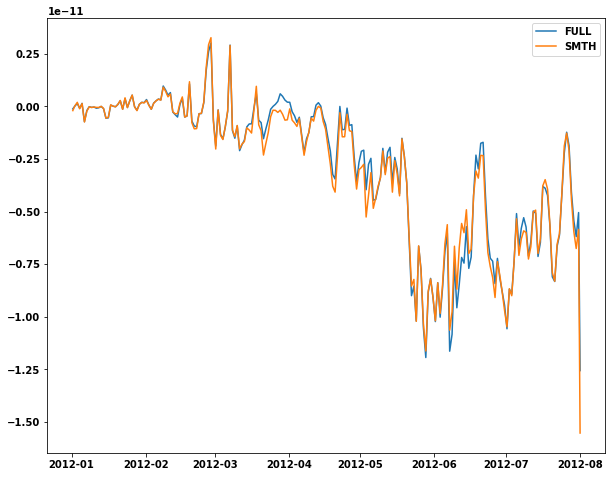

In [15]:
plt.figure(figsize=(10,8))
plt.plot(timer,(bt_f.mean(axis=2).mean(axis=1)*Bot_f.mean(axis=2).mean(axis=1)),label='FULL')
plt.plot(timer,(bt_t.mean(axis=2).mean(axis=1)*Bot_t.mean(axis=2).mean(axis=1)),label='SMTH')
plt.legend()

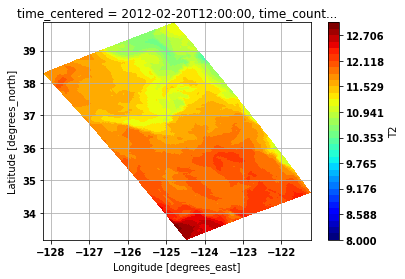

In [283]:
(varfw.T2[50,30:-30,30:200]-273).plot(x='nav_lon',y='nav_lat',levels=np.linspace(8,13,35),cmap='jet')
plt.grid()

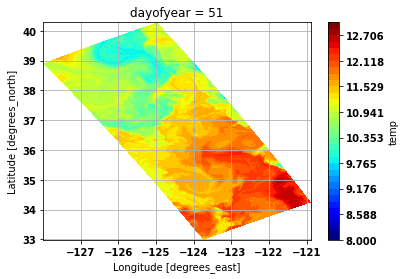

In [282]:
(tf[50]).plot(x='nav_lon_rho',y='nav_lat_rho',levels=np.linspace(8,13,35),cmap='jet')
plt.grid()

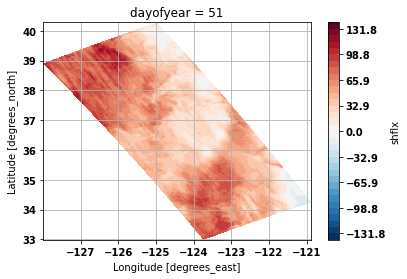

In [281]:
shf[50].plot(x='nav_lon_rho',y='nav_lat_rho',levels=np.linspace(-140,140,35))
plt.grid()